# Pricing of fixed income assets

Assuming an uncertain distribution of interest rates for different run times...

Given a cashflow $c_t$, for time periods $t=1,...,T$ (face values, coupon payments, ...)
[need to derive consistent interest rates for e.g. 1.5 years for coupons] ?

TBD


Net present value of cashflow is given by...

In [1]:
from qiskit_aqua.algorithms.components.uncertainty_models.multivariate_normal_distribution import MultivariateNormalDistribution
from qiskit_aqua.algorithms.components.uncertainty_problems.fixed_income_expected_value import FixedIncomeExpVal
import matplotlib.pyplot as plt
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, execute, Aer
import numpy as np
from qiskit_aqua.algorithms.single_sample import AmplitudeEstimation

In [2]:
# derive uncertainty model for the interest rates using real data
A = np.eye(2)
b = np.zeros(2)

# specify the lower and upper bounds for the different dimension
low = [-0.25, -0.1]
high = [0.5, 0.1]
mu = np.zeros(2)
sigma = np.eye(2)

# specify the number of qubits that are used to represent the different dimenions of the uncertainty model
num_qubits = [2, 2]

# construct corresponding distribution
u = MultivariateNormalDistribution(num_qubits, low, high, mu, sigma)

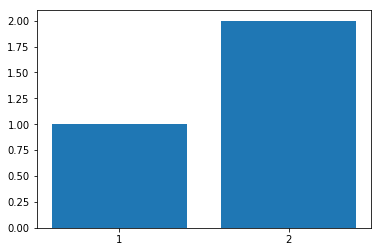

In [3]:
# specify cash flow
cf = [1.0, 2.0]
periods = range(1, len(cf)+1)

# plot cash flow
plt.bar(periods, cf)
plt.xticks(periods)
plt.show()

In [4]:
# estimate real value
cnt = 0
real_value = 0.0
for x1 in np.linspace(low[0], high[0], pow(2, num_qubits[0])):
    for x2 in np.linspace(low[1], high[1], pow(2, num_qubits[1])):
        prob = u.probabilities[cnt]
        for t in range(len(cf)):
            real_value += prob * (cf[t]/pow(1 + b[t], t+1) - (t+1)*cf[t]*np.dot(A[:, t], np.asarray([x1, x2]))/pow(1 + b[t], t+2))
        cnt += 1

In [5]:
# specify approximation factor
c_approx = 0.05

# get fixed income circuit factory
fixed_income = FixedIncomeExpVal(u, A, b, cf, c_approx)

In [6]:
# evaluate via sampling
q = QuantumRegister(fixed_income.num_target_qubits)
c = ClassicalRegister(1)
qc = QuantumCircuit(q, c)
fixed_income.build(qc, q, params={'i_state': range(u.num_target_qubits), 'i_objective': u.num_target_qubits})

qc.measure(q[u.num_target_qubits], c[0])

shots = 1000
job = execute(qc, backend=Aer.get_backend('qasm_simulator_py'), config={'shots': shots})
result = job.result()
value = result.get_counts()['1']/shots
print('value:     ', value)
print('estimator: ', np.round(fixed_income.value_to_estimator(value), decimals=4))
print('real value:', np.round(real_value, decimals=4))

value:      0.002
estimator:  2.8781
real value: 2.8845


In [7]:
result.get_counts()

{'0': 1022, '1': 2}

In [8]:
# set number of evaluation qubits (samples)
m = 3

# construct amplitude estimation 
ae = AmplitudeEstimation(m, fixed_income)

In [9]:
# get quantum circuit for amplitude estimation
qc = ae.construct_circuit()

In [10]:
# run circuit on statevector simulator
import qiskit
state_vector = np.asarray(execute(qc, qiskit.Aer.get_backend('statevector_simulator_py')).result().get_statevector(qc))

state_probabilities = np.real(state_vector.conj() * state_vector)

In [11]:
# evaluate results
a_probabilities, y_probabilities = ae.evaluate_results(state_probabilities)

a_items = [(a, p) for (a, p) in a_probabilities.items() if p > 1e-6]
y_items = [(y, p) for (y, p) in y_probabilities.items() if p > 1e-6]
a_items = sorted(a_items)
y_items = sorted(y_items)

# map estimated values to original range and extract probabilities
mapped_values = [fixed_income.value_to_estimator(a_item[0]) for a_item in a_items]
values = [a_item[0] for a_item in a_items]
y_values = [y_item[0] for y_item in y_items]
probabilities = [a_item[1] for a_item in a_items]
mapped_items = [(mapped_values[i], probabilities[i]) for i in range(len(mapped_values))]

# determine most likely estimator
estimator = None
max_prob = 0
for val, prob in mapped_items:
    if prob > max_prob:
        max_prob = prob
        estimator = val
print('Exact value:    \t%.4f' % real_value)
print('Estimated value:\t%.4f' % estimator)
print('Probability:    \t%.4f' % max_prob)

Exact value:    	2.8845
Estimated value:	2.8750
Probability:    	0.9650


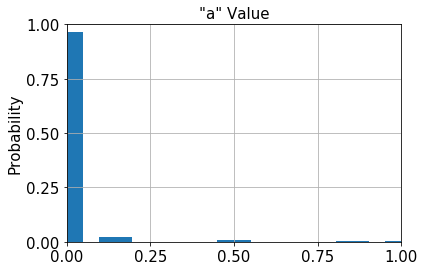

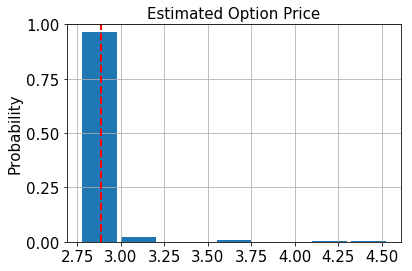

In [12]:
# plot estimated values for "a"
plt.bar(values, probabilities, width=0.5/len(probabilities))
plt.xticks([0, 0.25, 0.5, 0.75, 1], size=15)
plt.yticks([0, 0.25, 0.5, 0.75, 1], size=15)
plt.title('"a" Value', size=15)
plt.ylabel('Probability', size=15)
plt.xlim((0,1))
plt.ylim((0,1))
plt.grid()
plt.show()

# plot estimated values for option price
plt.bar(mapped_values, probabilities, width=1/len(probabilities))
plt.plot([real_value, real_value], [0,1], 'r--', linewidth=2)
plt.xticks(size=15)
plt.yticks([0, 0.25, 0.5, 0.75, 1], size=15)
plt.title('Estimated Option Price', size=15)
plt.ylabel('Probability', size=15)
plt.ylim((0,1))
plt.grid()
plt.show()